__Websites__<br>
    preprocessing methods outline - https://blog.ml.cmu.edu/2020/08/31/2-data-exploration/<br>
    outliers simple - https://analyticsindiamag.com/how-to-detect-and-treat-outliers-in-categorical-data/<br>
    pca collinearity removal/heatmap - https://towardsdatascience.com/how-do-you-apply-pca-to-logistic-regression-to-remove-multicollinearity-10b7f8e89f9b#:~:text=PCA%20in%20action%20to%20remove%20multicollinearity&text=PCA%20(Principal%20Component%20Analysis)%20takes,effectively%20eliminate%20multicollinearity%20between%20features.<br>
    vif - https://towardsdatascience.com/how-to-remove-multicollinearity-using-python-4da8d9d8abb2<br>
    pca 2D - https://towardsdatascience.com/principal-component-analysis-pca-from-scratch-in-python-7f3e2a540c51<br>
    pca 3D - https://drzinph.com/pca-visualized-with-3d-scatter-plots/<br>
    tsne -https://builtin.com/data-science/tsne-python<br>
    umap - https://blog.ml.cmu.edu/2020/08/31/2-data-exploration/<br>
    automatic outlier detection - https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/<br>
    3D t-sne and umap -  https://plotly.com/python/t-sne-and-umap-projections/#project-data-into-3d-with-tsne-and-pxscatter3d<br>
    knn - https://medium.datadriveninvestor.com/k-nearest-neighbors-in-python-hyperparameters-tuning-716734bc557f<br>
    hyperparameter tuning - https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74<br>
    model evaluation - https://medium.com/@MohammedS/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b<br>
    pydot and graphviz - https://github.com/WillKoehrsen/Data-Analysis/blob/master/random_forest_explained/Random%20Forest%20Explained.ipynb<br>

In [ ]:
#sklearn imports

from sklearn import metrics, model_selection, ensemble
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

#data handling imports
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# visualisation imports
# separated to reduce import time

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import umap.umap_ as umap

import plotly.express as px

import pydot

from mlxtend.plotting import plot_decision_regions

import time

__Preprocessing and Data Exploration__<br>
We want to predict edibility<br>
It can take values edible, poisonous or unknown. Unknown and poisonous are grouped together

First read the file and format it as desired

Missing values are stored as '?' characters so we convert to NaN to make the data easier to process

In [40]:
#cell to read raw data

#read contents of data file
file = pd.read_csv("agaricus-lepiota.data", header = None)

# create list to be used as headers
features = ['edibility', 'capShape', 'capSurface', 'capColor', 'bruises', 'odor', 
            'gillAttachment', 'gillSpacing', 'gillSize', 'gillColor', 
            'stalkShape', 'stalkRoot', 'stalkSurfaceAboveRing', 'stalkSurfaceBelowRing', 
            'stalkColorAboveRing', 'stalkColorBelowRing', 'veilType', 'veilColor', 
            'ringNumber', 'ringType', 'sporePrintColor', 'population', 'habitat']

#convert '?' to NaN
file.replace({'?': np.nan}, inplace=True)

#converting data frame to csv
file.to_csv("Data/agaricus-lepiota.csv", header=features, index=False)

data = pd.read_csv("Data/agaricus-lepiota.csv")

Simple data exploration for illustration<br>
Shows that the only feature containing missing values is 'stalkRoot', with 2480 null values

Created countplots to visualise some features attributes

In [ ]:
print(data.head(5)) # print first 5 rows
print(data.shape) # number of rows and columns
print(data.info()) # data types of each feature
print(data.isnull().sum()) # show how many NaN values in each feature

sns.set_theme(style="whitegrid")

# show even split of values in the feature to be predicted
data['edibility'] = LabelEncoder().fit_transform(data['edibility'])
fig = plt.figure(figsize=(7,5))
sns.countplot(x=data['edibility'])
plt.xlabel("Count")
plt.ylabel("Edibility")
plt.title("Countplot to Show number of Edible (0) and Poisonous (1) data points")
fig.savefig("Images/Edibility Countplot.png")

# this visualisation works best for features with a wide range of possible values
# chose 3 features as a starting point

f = plt.figure(figsize=(15,5))
f.add_subplot(1,3,1)
sns.countplot(x = data['population'])
sns.color_palette("pastel")
f.add_subplot(1,3,2)
sns.countplot(x = data['ringNumber'])
sns.color_palette("pastel")
f.add_subplot(1,3,3)
sns.countplot(x=data['gillColor'])
sns.color_palette("pastel")
plt.show()
f.savefig("Images/3 Countplots.png")

Our data takes character values so we will need to use label encoding - OneHot encoding not applicable due to the high dimensionality of the dataset. OneHot Encoding would be much less memory efficient

In [41]:
#cell for encoding the data

#use label encoding on all features that are categorical
le = LabelEncoder()

for i in range(len(features)):
   try:
      data[features[i]] = le.fit_transform(data[features[i]])
   except:
      pass

data.to_csv("Data/agaricus-lepiota-encoded.csv")

Using simple violin plots to show distibution of attributes within each feature. These demonstrated the need for outlier detection and elimination as there are features with vastly uneven attribute distribution

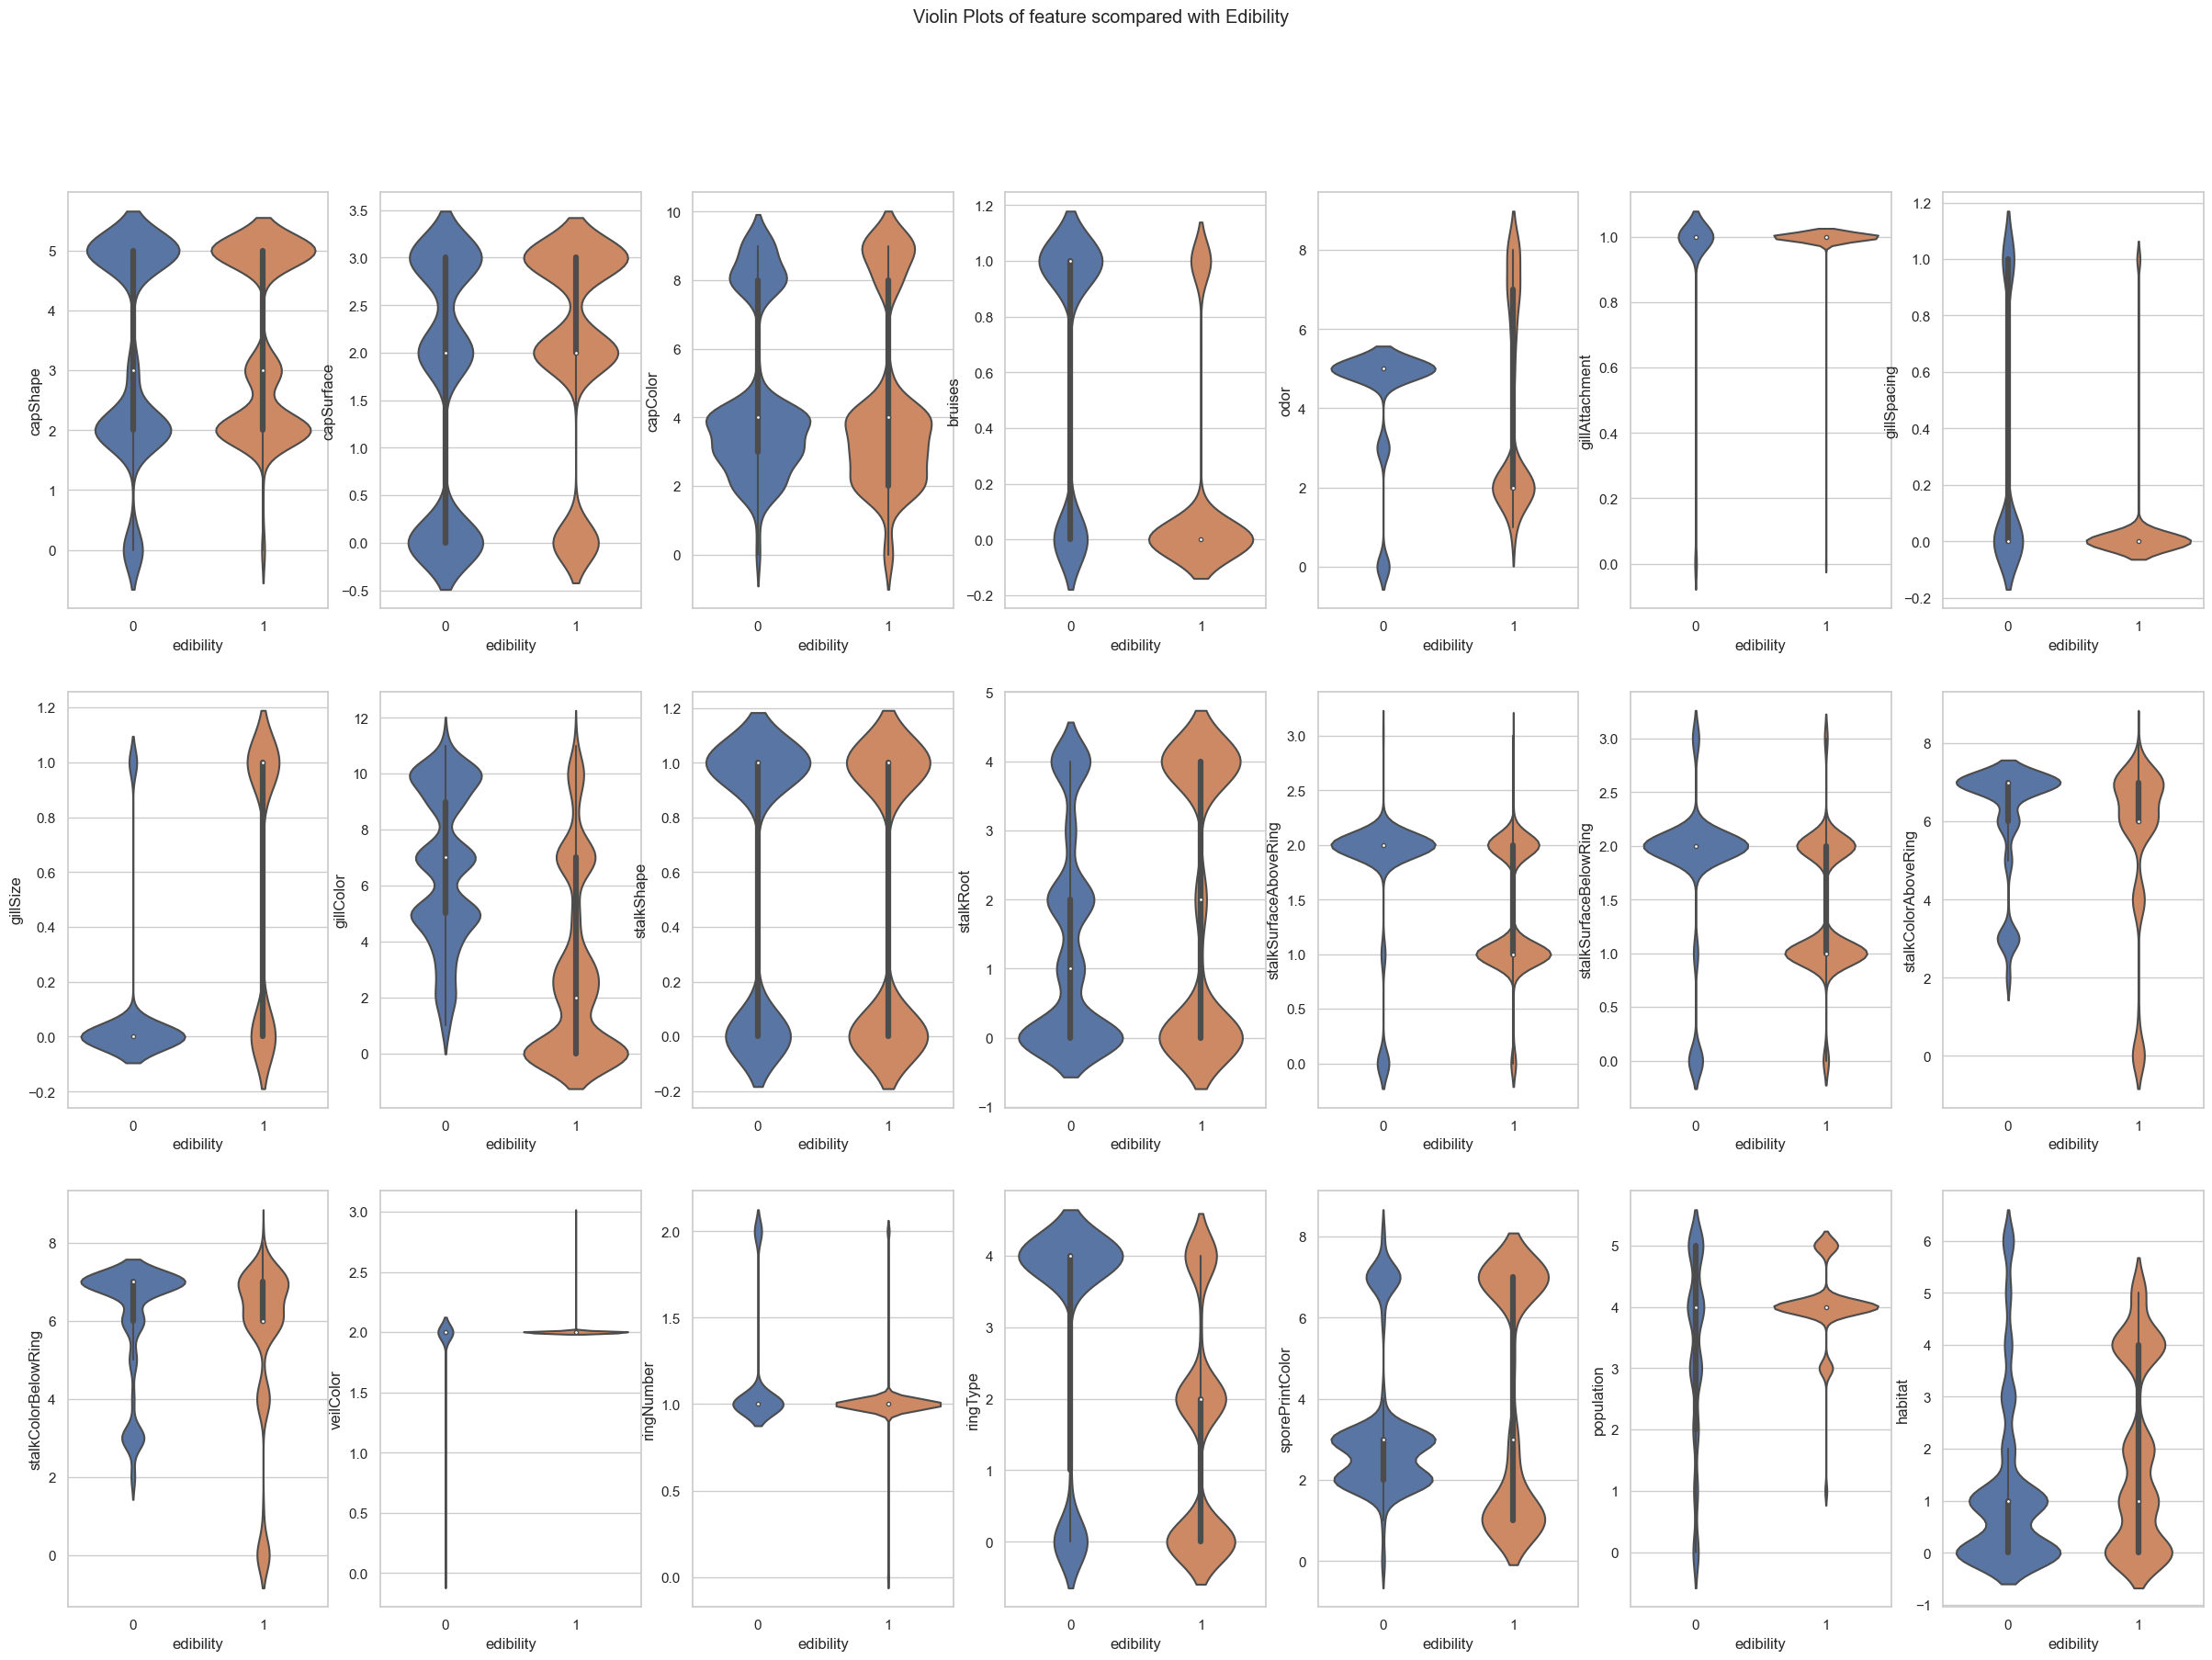

In [42]:
#violin plots to show distribution
figure, axes = plt.subplots(3,7,figsize = (30,20))
figure.suptitle("Violin Plots of feature scompared with Edibility")

graph_features = ['capShape', 'capSurface', 'capColor', 'bruises', 'odor', 
            'gillAttachment', 'gillSpacing', 'gillSize', 'gillColor', 
            'stalkShape', 'stalkRoot', 'stalkSurfaceAboveRing', 'stalkSurfaceBelowRing', 
            'stalkColorAboveRing', 'stalkColorBelowRing', 'veilColor', 
            'ringNumber', 'ringType', 'sporePrintColor', 'population', 'habitat']

count = 0
for i in range(0,3):
    for j in range(0,7):
        ax = sns.violinplot(ax = axes[i,j], data = data, x="edibility", y = graph_features[count])
        count +=1

plt.savefig("Images/Violin Plots.png")
plt.show()

Deletion methods of dealing with missing values<br>
**Only use one of the 2 cells below at a time**

**Don't use either if you're using the cell to predict missing values**

1. Delete any column containing missing values
2. Delete any row containing missing values

Since only one feature contains missing values (stalkRoot) method 1 is most effective as it deletes less data

In [43]:
#1.
#removes column with missing values which in our data is only stalkRoot
#one way to deal with missing values
print(data.shape)

treated_data = data.drop('stalkRoot', axis = 1).reset_index(drop=True)

features.remove("stalkRoot")
print(features)

# show how much data is lost
print(treated_data.shape)

#convert dataframe to csv
treated_data.to_csv("Data/agaricus-lepiota-no-stalkRoot.csv")

#print(data.head(10))

(8124, 23)
['edibility', 'capShape', 'capSurface', 'capColor', 'bruises', 'odor', 'gillAttachment', 'gillSpacing', 'gillSize', 'gillColor', 'stalkShape', 'stalkSurfaceAboveRing', 'stalkSurfaceBelowRing', 'stalkColorAboveRing', 'stalkColorBelowRing', 'veilType', 'veilColor', 'ringNumber', 'ringType', 'sporePrintColor', 'population', 'habitat']
(8124, 22)


In [ ]:
#2.
#removes all rows that have missing values
print(data.shape)

treated_data = data[data['stalkRoot'] != 4].reset_index(drop=True)
 
# show how much data is lost
print(treated_data.shape)

#convert dataframe to csv
treated_data.to_csv("Data/agaricus-lepiota-NaN-removed.csv")

Alternative way to deal with missing values: Use classifier based on values which aren't missing to predict the missing values<br>
Need to be careful to avoid overfitting (as with any predictor)

Could also set the values to some default or mean value


In [ ]:
#predict missing values for stalkRoot

#drop 'edibility' from dataframe as it will be the target feature in the later models
#It would be a bad idea to use 'edibility' to predict missing 'stalkRoot' values then use those values to later predict 'edibility'
NaN_predict = data.drop('edibility', axis = 1).reset_index(drop=True)

#split into set that contains missing values for 'stalkRoot' and set that does not contan missing values for 'stalkRoot'
#The 'NaN' values are encoded to be '4' so they are removed
NaN_train_data = NaN_predict[NaN_predict['stalkRoot']!= 4].copy()
NaN_test_data = NaN_predict[NaN_predict['stalkRoot'] == 4].copy()

#split data missing values into train and test set
NaN_X_train = NaN_train_data.drop('stalkRoot', axis = 1).reset_index(drop=True)
NaN_y_train = NaN_train_data['stalkRoot']

NaN_X_test = NaN_test_data.drop('stalkRoot', axis = 1).reset_index(drop=True)

#create random forest class
rfc = RandomForestClassifier()

#fit and predict data
rfc.fit(NaN_X_train,NaN_y_train)
y_pred = rfc.predict(NaN_X_test)

#set NaN values to be the predicted values
rounded_data = (np.rint(y_pred)).astype(int)
NaN_test_data['stalkRoot'] = rounded_data

NaN_test_data.to_csv("Data/predicted-missing-values.csv")

#combine the two dataframes to make the complete dataset
frames = [NaN_train_data, NaN_test_data]
treated_data = pd.concat(frames)
treated_data = treated_data.sort_index()
treated_data.insert(0, column = 'edibility', value = data['edibility'])

treated_data.to_csv("Data/full-data.csv")

In [44]:
X = treated_data.drop('edibility', axis = 1).reset_index(drop=True)
y = treated_data['edibility'] 

graph_labels = []
for i in y:
    if i == 0:
        graph_labels.append("Edible")
    else:
        graph_labels.append("Poisonous")

#scale the data for correct visualisation
data_scaled = StandardScaler().fit_transform(X)

__Data Visualisation__

1. PCA<br>
Linear method so less complex than others such as T-SNE and UMAP, meaning it takes much less time<br>
But not so useful to visualise our dataset as shown by the explained variance and scree plot<br>

However we could be possibly use PCA to reduce multicollinearity but there are other methods to also consider<br>
For example using the first 8 PC's greatly reduces the dimesionality of out dataset while mostly maintaining important information

In [ ]:
#data visualisation pca 2D
pca = PCA(random_state=42)
pca_features = pca.fit_transform(data_scaled)

#calculate percieved variance
per_var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
print(per_var)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.rcParams["figure.figsize"] = (12,8)

#to be seen on a 2D-plot we can only use PC1 and PC2 which gives us the highest explained variance but still very low
#around 19% + 12% = 31% explained variance which is bad
plt.bar(x= range(1,len(per_var)+1), height = per_var, tick_label = labels)
plt.title('Scree Plot to Show the Explained Variance of Each PC')
plt.xlabel("PCA NO.")
plt.ylabel("Explained Variance (%)")
plt.savefig("Images/PCA_distribution")
plt.show()

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

pca_df = pd.DataFrame({'pca_1': pca_features[:,0], 'pca_2': pca_features[:,1], 'Edibility': graph_labels})
print(pca_df)

#plot pca 1 and pca 2
sns.scatterplot(x = 'pca_1', y = 'pca_2', hue = 'Edibility', data = pca_df)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title("2D Visualisation using PCA")
plt.savefig("Images/PCA/2D PCA")
plt.show()

In [ ]:
#PCA 3D
pca = PCA(n_components = 3, random_state=42)
pca_features = pca.fit_transform(data_scaled)

#calculate percieved variance
per_var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
print(per_var)
print(pca_features)

treated_data["edibility"] = treated_data["edibility"].astype(str)

#plot PCA 3D
pca_fig = px.scatter_3d(
    pca_features, x=0, y=1, z=2,
    color=graph_labels, labels={'color': 'Edibility'},
    title = "Dimensionality reduction using PCA to visualise the dataset"
)
pca_fig.update_traces(marker_size=8)

pca_fig.update_layout(scene = dict(
                    xaxis_title='PCA 1',
                    yaxis_title='PCA 2',
                    zaxis_title='PCA 3')
)

#save as html to view the 3D graph interactively
pca_fig.write_html("Images/PCA/PCA-3D.html")

pca_fig.show()

2. T-SNE<br>
Unlike pca, it's not linear so much more complex<br>
The result of t-SNE is greatly affected by the 'perplexity' hyperparameter<br>
Try perplexity values in the range 5-100 default is 30. Higher perplexity takes longer but may be better

In [ ]:
#data visualisation t-sne 2D
n_components = 2
tsne = TSNE(n_components, perplexity=50, random_state = 42)
tsne_features = tsne.fit_transform(data_scaled)

#create data-frame used to plot
tsne_df = pd.DataFrame({'tsne_1': tsne_features[:,0], 'tsne_2': tsne_features[:,1], 'label': treated_data['edibility']})

#plot tnse 1 and tsne 2
sns.scatterplot(x = 'tsne_1', y = 'tsne_2', hue = 'label', data = tsne_df)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("2D Visualisation using t-SNE")
plt.savefig("Images/t-SNE/2D t-SNE")
plt.show()

In [ ]:
#3D t-SNE using plotly
n_components = 3

#create t-SNE class and set hyperparameters
tsne = TSNE(n_components, perplexity=50, random_state=42)
tsne_features = tsne.fit_transform(data_scaled)

treated_data["edibility"] = treated_data["edibility"].astype(str)

#plot t-SNE
tsne_fig = px.scatter_3d(
    tsne_features, x=0, y=1, z=2,
    color=graph_labels, labels={'color': 'Edibility'},
    title = "Dimensionality reduction using t-SNE to visualise the dataset"
)
tsne_fig.update_traces(marker_size=8)

tsne_fig.update_layout(scene = dict(
                    xaxis_title='t-SNE 1',
                    yaxis_title='t-SNE 2',
                    zaxis_title='t-SNE 3')
)

#save graph as html to be viewed interactively
tsne_fig.write_html("Images/t-SNE/t-SNE-3D.html")

tsne_fig.show()

3. UMAP <br>
UMAP works very similarly to t-SNE but gets more efficient for higher volumes of data <br>
Result greatly affected by n_neighbors and min_dist hyperparameters <br>
For n_neighbors try range 5-100 and min_dist 0.1-1

In [ ]:
#data visualisation UMAP

#create UMAP class and set hyperparameters
fit = umap.UMAP(
    n_neighbors=50,
    min_dist=0.25,
    n_components=2,
    random_state = 42
)

umap_features = fit.fit_transform(data_scaled)

#create datafram to plot UMAP
umap_df = pd.DataFrame({'umap_1': umap_features[:,0], 'umap_2': umap_features[:,1], 'Edibility': graph_labels})


#plot 2D UMAP
sns.scatterplot(x = 'umap_1', y = 'umap_2', hue = 'Edibility', data = umap_df)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("2D Visualisation using UMAP")
plt.savefig("Images/UMAP/2D UMAP")
plt.show()

In [ ]:
#UMAP 3D using plotly

#create UMAP class and set hyperparameters
fit = umap.UMAP(
    n_neighbors=50,
    min_dist=0.75,
    n_components=3,
    random_state = 42
)

umap_features = fit.fit_transform(data_scaled)

treated_data["edibility"] = treated_data["edibility"].astype(str)

#plot UMAP 3D
umap_fig = px.scatter_3d(
    umap_features, x=0, y=1, z=2,
    color=graph_labels, labels={'color': 'Edibility'},
    title = "Dimensionality reduction using UMAP to visualise the dataset"
)
umap_fig.update_traces(marker_size=5)

umap_fig.update_layout(scene = dict(
                    xaxis_title='UMAP 1',
                    yaxis_title='UMAP 2',
                    zaxis_title='UMAP 3')
)

#save graph as html to be viewed interactively
umap_fig.write_html("Images/UMAP/UMAP-3D.html")
umap_fig.show()

Now deal with outliers<br>
We define outliers as values a category can take which is significantly more or less frequent than the others<br>

Detect outliers based on relative frequency and remove any rows containing outliers in at least one category<br>
Then show histogram of data distribution within categories containing outliers

In [ ]:
#cell to detect and remove outliers

#decides relative frequency threshold, below which values are considered outliers
threshold = 0.01
contains_outliers = []
outlier_features = []
num_values = data.nunique()

print("Original dataset:",treated_data.shape)

#loop through categories and identify which contain outliers according to the above definitions
for i in range(len(features)):
    if num_values[i] > 2:
        value_frequencies = treated_data[features[i]].value_counts(normalize=True) #normalize parameter converts values to relative frequency

        #loop through features that contain outliers and remove the all rows that contain the outlier values
        for j in range(len(value_frequencies)):
            if value_frequencies.iloc[j] < threshold:
                treated_data = treated_data[treated_data[features[i]] != value_frequencies.index[j]]
                contains_outliers.append(value_frequencies)
                outlier_features.append(features[i])

print("Outliers removed:",treated_data.shape)

#now display histogram
sns.set_theme(style = None)

if len(contains_outliers) != 0:
    for x in range(len(contains_outliers)):
        outlier_histogram = plt.hist(contains_outliers[x], alpha = 0.5, label = outlier_features[x])

    plt.legend(loc='upper right',prop={'size': 6})
    plt.xlabel("Relative frequency")
    plt.ylabel("Encoded label")
    plt.title("Histograms showing the relative frequency of attributes within each feature")
    plt.savefig("Images/Frequency Histogram.png")
    plt.show()

Now check for any features which only contain one value<br>
These won't affect the model performance as the entire feature is constant so we can remove them to simplify the dataset

In [ ]:
#cell to remove redundant features

num_values = treated_data.nunique()
removed_features = []

#loop that finds features that have only one attribute value
j = 0
for i in range(len(features)):
    if num_values[i] == 1:
        treated_data = treated_data.drop(features[j],axis=1).reset_index(drop=True)
        removed_features.append(features[j])
        features.remove(features[j])
    else:
        j += 1

#remove features
X = treated_data.drop('edibility', axis = 1).reset_index(drop=True) #update treated X
y = treated_data['edibility'] #update treated y

print("Removed",removed_features)

Display heatmap to explore correlation between features<br>
Multicollinearity can lead to overfitting so need to remove correlated features

In [ ]:
#cell that uses variance inflation factor to identify and remove highly correlated data

#create a heatmap showing feature correlation
fig = plt.figure(figsize=(25, 20))
sns.heatmap(X.corr(), annot=True)
plt.savefig("Images/Heatmap.png")

#as you can see from heatmap there are some features with high correlation

#create dataframe with all features and their VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
						for i in range(len(X.columns))]

print(vif_data)

features_to_drop = []

#loop through the features and add those with VIF higher than 5 to a list
for i in range(len(X.columns)):
	if vif_data["VIF"][i] > 5:
		drop = vif_data["VIF"][i]
		features_to_drop.append(vif_data["feature"][i])

#create new dataframe identified features removed
uncorrelated_X = X.drop(features_to_drop, axis = 1).reset_index(drop=True)

#scale for visualisation
uncorrelated_X_scaled = StandardScaler().fit_transform(uncorrelated_X)

cleaned_features = uncorrelated_X.columns

#generally features with VIF > 5 get removed but we can experiment with slightly higher i.e > 6

#create heatmap to compare feature correlation of new dataframe
fig2 = plt.figure(figsize=(25, 20))
sns.heatmap(uncorrelated_X.corr(), annot=True)
plt.savefig("Images/Heatmap 2.png")
plt.show()

#as seen by second heatmap these have much less colinearality

__All the data exploration, preprocessing and Visualisation is now complete__<br>
The following cells contain code for hyperparamter exploration, model comparison and model evaluation for 3 models: K-Nearest Neighbours(KNN), Random Forest Classifier(RFC) and Support Vector Classifier(SVC)

__Models__ 


1. K-nearest neighbours<br>
Decsion Regions exploration n_neighbours and leaf_size

In [ ]:
# knn hyperparameter exploration: n_neighbours decision regions

#create range of n_neighbours to explore
X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2, random_state=42)
n_neighbours = [1, 2, 5, 10, 12, 15, 25] # points on the accuracy graph with changes

#for each candidate value plot a decision region graph
for i in range(len(n_neighbours)):
    knn = KNeighborsClassifier(n_neighbors=n_neighbours[i])
    knn.fit(X_train, y_train)

    for j in range(2):
        plt.subplot(2,1,j+1)
        plot_decision_regions(X_test.values, y_test.values, clf = knn, legend = 2, feature_index = [0,2], filler_feature_values={1: j}, filler_feature_ranges={1:0.75})
        plt.title("n_neighbors="+str(n_neighbours[i])+" gillSpacing="+str(j))
        plt.xlabel("capSurface")
        plt.ylabel("habitat")
    
    plt.tight_layout()
    plt.savefig("Images/KNN/KNN Regions/n_neighbours = "+str(n_neighbours[i])+".png")
    plt.show()
    plt.close()

In [ ]:
# knn hyperparameter exploration: leaf_size decision regions

#create range of n_neighbours to explore
X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2, random_state=42)
leaf_sizes = [1, 2, 5, 10, 15, 25 ,50, 100] # points on the accuracy graph with changes

#for each candidate value plot a decision region graph
for i in range(len(leaf_sizes)):
    knn = KNeighborsClassifier(leaf_size=leaf_sizes[i])
    knn.fit(X_train, y_train)

    for j in range(2):
        plt.subplot(2,1,j+1)
        plot_decision_regions(X_test.values, y_test.values, clf = knn, legend = 2, feature_index = [0,2], filler_feature_values={1: j}, filler_feature_ranges={1:0.75})
        plt.title("leaf_size ="+str(leaf_sizes[i])+" gillSpacing="+str(j))
        plt.xlabel("capSurface")
        plt.ylabel("habitat")
    
    plt.tight_layout()
    plt.savefig("Images/KNN/KNN Regions/leaf_size = "+str(leaf_sizes[i])+".png")
    plt.show()
    plt.close()

Exploration of accuarcy and time against Knn hyperparameters

In [ ]:
# knn hyperparameter exploration: accuracy v and time vs n_neighbors

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2, random_state=42)
n_neighbours = range(1,1000)

#create lists to append times and accuracies to
accuracies = []
times = []

#measure the accuracy and time taken of knn modle for each value of n_neighbours
for i in range(len(n_neighbours)):
    knn = KNeighborsClassifier(n_neighbors=n_neighbours[i])
    start_time = time.time()
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    end_time = time.time()
    accuracies.append(accuracy_score(y_test, y_pred))
    times.append(end_time - start_time)

#plot both graphs side by side to be compared
figure, axes = plt.subplots(1,2,figsize = (12,6))
figure.suptitle("Accuracy and Time Plots against n_neighbours")

ax = sns.lineplot(x = n_neighbours, y = accuracies, ax = axes[0])
ax.set(xlabel='n_neighbours', ylabel='Accuracy')
ax2 = sns.lineplot(x = n_neighbours, y = times, ax = axes[1])
ax2.set(xlabel='n_neighbours', ylabel='Time (s)')
plt.savefig("Images/KNN/KNN accuracy and time vs n_neighbours.png")
plt.show()


In [ ]:
# knn hyperparameter exploration: accuracy v and time vs leaf size

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2, random_state=42)
leaf_sizes = range(1,1000)

#create lists to append times and accuracies to
accuracies = []
times = []

#measure the accuracy and time taken of knn modle for each value of leaf_size
for i in range(len(leaf_sizes)):
    knn = KNeighborsClassifier(leaf_size=leaf_sizes[i])
    start_time = time.time()
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    end_time = time.time()
    accuracies.append(accuracy_score(y_test, y_pred))
    times.append(end_time - start_time)

#plot both graphs side by side to be compared
figure, axes = plt.subplots(1,2,figsize = (12,6))
figure.suptitle("Accuracy and Time Plots against leaf_size")

ax = sns.lineplot(x = leaf_sizes, y = accuracies, ax = axes[0])
ax.set(xlabel='leaf_size', ylabel='Accuracy')
ax2 = sns.lineplot(x = leaf_sizes , y = times, ax = axes[1])
ax2.set(xlabel='leaf_size', ylabel='Time (s)')
plt.savefig("Images/KNN/KNN accuracy and time vs leaf_size.png")
plt.show()


Now we can make informed decisions about hyperparameter candidate value ranges for cross fold validation of the Knn model

In [ ]:
#cell for  knn model

# hyperparameters
n_neighbors = list(range(1,30))
weights = ['uniform','distance']
leaf_size = list(range(1,50))
p = [1,2]

# create dictionary
random_grid = {'n_neighbors': n_neighbors,
               'weights': weights,
               'algorithm': ['kd_tree'],
               'leaf_size': leaf_size,
               'p': p}

# baseline model
knn_baseline = KNeighborsClassifier()

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2)
knn_baseline.fit(X_train, y_train)
baseline_knn_pred = knn_baseline.predict(X_test)

# random hyperparameter values
knn_random = RandomizedSearchCV(estimator = knn_baseline, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring = 'accuracy')

knn_random.fit(X_train, y_train)

best_random_values = knn_random.best_params_
print("\n", best_random_values, "\n")
best_random_knn = knn_random.best_estimator_
print(best_random_knn)

#predict using best random model and get model accuracy report
best_random_pred = best_random_knn.predict(X_test)

#create a refined hyperparameter grid with values close to the best random estimator to look for further optimization
# fits may fail if n_neighbors or leaf_size < 15 however they will just be skipped so this is okay
param_grid = {
    'n_neighbors': list(range((best_random_values['n_neighbors']-10),(best_random_values['n_neighbors']+10))),
    'weights': [best_random_values['weights']],
    'algorithm': ['kd_tree'],
    'leaf_size': list(range((best_random_values['leaf_size']-15),(best_random_values['leaf_size']+15))),
    'p': [best_random_values['p']]
}

knn_refined = KNeighborsClassifier()

# find the best scoring model using the refined hyperparameter grid
knn_grid = GridSearchCV(estimator = knn_refined, param_grid = param_grid, cv = 3, verbose=2, n_jobs = -1, scoring = 'accuracy')

knn_grid.fit(X_train, y_train)

print("\n", knn_grid.best_params_, "\n")
best_grid_knn = knn_grid.best_estimator_
print(best_grid_knn)

# predict with refined model
best_refined_pred = best_grid_knn.predict(X_test)

#create figure to plot 3 confusion matrix on of each model iteration
figure, axes = plt.subplots(1,3,figsize = (15,5))
figure.suptitle("Confusion matrices of each model iteration")

#create confusion matrix and labels for clear plotting
cf_matrix = confusion_matrix(y_test, baseline_knn_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

#show model accuracy report
print("Baseline\n")
print(classification_report(y_test,baseline_knn_pred))

print(cf_matrix)

#plot confusion matrix
ax = sns.heatmap(cf_matrix, annot = labels,fmt = '', cmap = 'Blues', ax = axes[0], cbar = False)

#show model accuracy report
print("Random Search\n")
print(classification_report(y_test,best_random_pred))

#create second confusion matrix and labels for clear plotting
cf_matrix_2 = confusion_matrix(y_test, best_random_pred)

print(cf_matrix_2)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_2.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_2.flatten()/np.sum(cf_matrix_2)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

#plot second matrix
ax = sns.heatmap(cf_matrix_2, annot = labels,fmt = '', cmap = 'Blues', ax = axes[1],cbar = False)

print("Grid Search\n")
print(classification_report(y_test,best_refined_pred))

#create third confusion matrix and labels for clear plotting
cf_matrix_3 = confusion_matrix(y_test, best_refined_pred)

print(cf_matrix_3)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_3.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_3.flatten()/np.sum(cf_matrix_3)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

#plot third confusion matrix and save figure as png
ax = sns.heatmap(cf_matrix_3, annot = labels,fmt = '', cmap = 'Blues', ax = axes[2])

plt.savefig("Images/KNN/Confusion Matrix.png")
plt.show()

__2. Random Forest Classifier(RFC)__<br>
Decision region exploration of RFC hyperparameters

In [ ]:
# RFC n_estimators hyperparameter exploration

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2)

#create list of n_estimators and fit a model for each
n_estimators = [1,2,5,10,20,50,100,200,400,600,800,1000]

for n_estimator in n_estimators:
    rfc_n_estimator = RandomForestClassifier(n_estimators= n_estimator, random_state = 42)
    rfc_n_estimator.fit(X_train,y_train)

    #create a decision region plot for each value of n_estimators
    for i in range(2):
        plt.subplot(2,1,i+1)
        plot_decision_regions(X_test.values, y_test.values, clf = rfc_n_estimator, legend = 2, feature_index = [0,2], filler_feature_values={1: i}, filler_feature_ranges={1:0.75})
        title = "n_estimators = " + str(n_estimator) + " gillSpacing="+str(i)
        print(title)
        plt.title(title)
        plt.xlabel("capSurface")
        plt.ylabel("habitat")

    #save plot as png
    image_directory = "Images/RFC/RFC Regions/n_estimators = " + str(n_estimator) + ".png"
    print(image_directory)
    plt.tight_layout()
    plt.savefig(image_directory)
    plt.show()
    plt.close()

In [ ]:
# RFC max_depth hyperparameter exploration

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2)

#create list of max_depth candidate values and fit an RFC model for each
max_depths = [1,2,5,10,20,50,100,200]

for max_depth in max_depths:
    rfc_max_depth = RandomForestClassifier(max_depth= max_depth, random_state = 42)
    rfc_max_depth.fit(X_train,y_train)

    #plot a decision region graph for each candidate value
    for i in range(2):
        plt.subplot(2,1,i+1)
        plot_decision_regions(X_test.values, y_test.values, clf = rfc_max_depth, legend = 2, feature_index = [0,2], filler_feature_values={1: i}, filler_feature_ranges={1:0.75})
        title = "max_depth = " + str(max_depth) + " gillSpacing="+str(i)
        plt.title(title)
        plt.xlabel("capSurface")
        plt.ylabel("habitat")

    #save plots as png
    image_directory = "Images/RFC/RFC Regions/max_depth = " + str(max_depth) + ".png"
    print(image_directory)
    plt.tight_layout()
    plt.savefig(image_directory)
    plt.show()
    plt.close()

In [ ]:
# RFC min_samples_split hyperparameter exploration

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2)

#create a list for a range of candidate values and fit an RFC model for each
min_samples_splits = [2,5,10,20,50,100,200]

for min_samples_split in min_samples_splits:
    rfc_min_samples_split = RandomForestClassifier(min_samples_split= min_samples_split, random_state = 42)
    rfc_min_samples_split.fit(X_train,y_train)

    #plot a decision region graph for each candidate value
    for i in range(2):
        plt.subplot(2,1,i+1)
        plot_decision_regions(X_test.values, y_test.values, clf = rfc_min_samples_split, legend = 2, feature_index = [0,2], filler_feature_values={1: i}, filler_feature_ranges={1:0.75})
        title = "min_samples_split = " + str(min_samples_split) + " gillSpacing="+str(i)
        plt.title(title)
        plt.xlabel("capSurface")
        plt.ylabel("habitat")

    #save plots as png
    image_directory = "Images/RFC/RFC Regions/min_samples_split = " + str(min_samples_split) + ".png"
    print(image_directory)
    plt.tight_layout()
    plt.savefig(image_directory)
    plt.show()
    plt.close()

In [ ]:
# RFC min_samples_leaf hyperparameter exploration

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2)

#create list for range of candidate values and fit an RFC model
min_samples_leaves = [2,5,10,20,50,100,200]

for min_samples_leaf in min_samples_leaves:
    rfc_min_samples_leaf = RandomForestClassifier(min_samples_leaf= min_samples_leaf, random_state = 42)
    rfc_min_samples_leaf.fit(X_train,y_train)

    #plot decision region graph for each candidate value
    for i in range(2):
        plt.subplot(2,1,i+1)
        plot_decision_regions(X_test.values, y_test.values, clf = rfc_min_samples_leaf, legend = 2, feature_index = [0,2], filler_feature_values={1: i}, filler_feature_ranges={1:0.75})
        title = "min_samples_leaf = " + str(min_samples_leaf) + " gillSpacing="+str(i)
        plt.title(title)
        plt.xlabel("capSurface")
        plt.ylabel("habitat")

    #save plots as png
    image_directory = "Images/RFC/RFC Regions/min_samples_leaf = " + str(min_samples_leaf) + ".png"
    print(image_directory)
    plt.tight_layout()
    plt.savefig(image_directory)
    plt.show()
    plt.close()

Exploration of accuarcy and time against RFC hyperparameters

In [ ]:
# RFC hyperparameter exploration: accuracy and time vs n_estimators

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2, random_state=42)
n_estimators = range(1,1000)

#create lists to store times and accuracies
times = []
accuracies = []

#for each candidate value calculate the time taken and accuracy of the RFC model
for i in range(len(n_estimators)):
    start_time = time.time()
    rfc = RandomForestClassifier(n_estimators=n_estimators[i])
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    end_time = time.time()
    accuracies.append(accuracy_score(y_test, y_pred))
    times.append(end_time - start_time)

#plot these graphs on a figure for clear comparision
figure, axes = plt.subplots(1,2,figsize = (12,6))
figure.suptitle("Accuracy and Time Plots against n_estimators")

ax = sns.lineplot(x = n_estimators, y = accuracies, ax = axes[0])
ax.set(xlabel='n_esimators', ylabel='Accuracy')
ax2 = sns.lineplot(x = n_estimators, y = times, ax = axes[1])
ax2.set(xlabel='n_estimators', ylabel='Time (s)')
plt.savefig("Images/RFC/RFC accuracy and time vs n_estimators.png")
plt.show()

In [ ]:
# RFC hyperparameter exploration: accuracy and time vs max_depth

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2, random_state=42)
max_depths = range(1,1000)

#create lists to store times and accuracies
times = []
accuracies = []

#for each candidate value calculate the time taken and accuracy of the RFC model
for i in range(len(max_depths)):
    start_time = time.time()
    rfc = RandomForestClassifier(max_depth=max_depths[i])
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    end_time = time.time()
    accuracies.append(accuracy_score(y_test, y_pred))
    times.append(end_time - start_time)

#plot these graphs on a figure for clear comparision
figure, axes = plt.subplots(1,2,figsize = (12,6))
figure.suptitle("Accuracy and Time Plots against max_depth")

ax = sns.lineplot(x = max_depths, y = accuracies, ax = axes[0])
ax.set(xlabel='max_depth', ylabel='Accuracy')
ax2 = sns.lineplot(x = max_depths, y = times, ax = axes[1])
ax2.set(xlabel='max_depth', ylabel='Time (s)')
plt.savefig("Images/RFC/RFC accuracy and time vs max_depth.png")
plt.show()

In [ ]:
# RFC hyperparameter exploration: accuracy and time vs min_samples_split

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2, random_state=42)
min_samples_splits = range(2,1000)

#create lists to store times and accuracies
times = []
accuracies = []

#for each candidate value calculate the time taken and accuracy of the RFC model
for i in range(len(min_samples_splits)):
    print(i)
    start_time = time.time()
    rfc = RandomForestClassifier(min_samples_split=min_samples_splits[i])
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    end_time = time.time()
    accuracies.append(accuracy_score(y_test, y_pred))
    times.append(end_time - start_time)

#plot these graphs on a figure for clear comparision
figure, axes = plt.subplots(1,2,figsize = (12,6))
figure.suptitle("Accuracy and Time Plots against min_samples_split")

ax = sns.lineplot(x = min_samples_splits, y = accuracies, ax = axes[0])
ax.set(xlabel='min_samples_split', ylabel='Accuracy')
ax2 = sns.lineplot(x = min_samples_splits, y = times, ax = axes[1])
ax2.set(xlabel='min_samples_split', ylabel='Time (s)')
plt.savefig("Images/RFC/RFC accuracy and time vs min_samples_split.png")
plt.show()

In [ ]:
# RFC hyperparameter exploration: accuracy and time vs min_samples_leaf

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2, random_state=42)
min_samples_leaves = range(1,1000)

#create lists to store times and accuracies
times = []
accuracies = []

#for each candidate value calculate the time taken and accuracy of the RFC model
for i in range(len(min_samples_leaves)):
    print(i)
    start_time = time.time()
    rfc = RandomForestClassifier(min_samples_leaf=min_samples_leaves[i])
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    end_time = time.time()
    accuracies.append(accuracy_score(y_test, y_pred))
    times.append(end_time - start_time)

#plot these graphs on a figure for clear comparision
figure, axes = plt.subplots(1,2,figsize = (12,6))
figure.suptitle("Accuracy and Time Plots against min_samples_leaf")

ax = sns.lineplot(x = min_samples_leaves, y = accuracies, ax = axes[0])
ax.set(xlabel='min_samples_leaf', ylabel='Accuracy')
ax2 = sns.lineplot(x = min_samples_leaves, y = times, ax = axes[1])
ax2.set(xlabel='min_samples_leaf', ylabel='Time (s)')
plt.savefig("Images/RFC/RFC accuracy and time vs min_samples_leaf.png")
plt.show()

Now we can make informed decisions about hyperparameter candidate value ranges for cross fold validation of the RFC model

In [ ]:
#cell for RandomForestClassifier

#create distribution of chosen hyperparamaters to be used in random search
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [3, 5, 10]
min_samples_leaf = [2, 4, 6]
bootstrap = [True, False]

#create dictionary with distribution of chosen hyperparameters
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

#basline model to compare to when optimising
rf = RandomForestClassifier()

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2)

baseline_rfc = RandomForestClassifier(random_state = 42, n_estimators = 10)

baseline_rfc.fit(X_train, y_train)
baseline_rfc_pred = baseline_rfc.predict(X_test)


#find best scoring random hyperparameter combination
rfc_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring = 'accuracy')

rfc_random.fit(X_train, y_train)
best_random_values = rfc_random.best_params_

print("\n", rfc_random.best_params_, "\n")
best_random_rfc = rfc_random.best_estimator_
print(best_random_rfc)

#predict using best random model and get model accuracy report
best_pred = best_random_rfc.predict(X_test)

#create a refined hyperparameter grid with values close to the best random estimator to look for further optimization
param_grid = {
    'n_estimators': list(range((best_random_values['n_estimators']-20),(best_random_values['n_estimators']+20))),
    'max_features': [best_random_values['max_features']],
    'max_depth': list(range((best_random_values['max_depth']-9),(best_random_values['max_depth']+10))),
    'min_samples_split': list(range((best_random_values['min_samples_split']-1),(best_random_values['min_samples_split']+1))),
    'min_samples_split': list(range((best_random_values['min_samples_leaf']-1),(best_random_values['min_samples_leaf']+1))),
    'bootstrap': [best_random_values['bootstrap']]
}

rf2 = RandomForestClassifier()

#find the best scoring model using the refined hyperparameter grid
rfc_grid = GridSearchCV(estimator = rf2, param_grid = param_grid, cv = 3, verbose=2, n_jobs = -1, scoring = 'accuracy')

rfc_grid.fit(X_train, y_train)

print("\n", rfc_grid.best_params_, "\n")
best_grid_rf = rfc_grid.best_estimator_
print(best_grid_rf)

#predict values using this model and show accuracy to compare models later
best_pred2 = best_grid_rf.predict(X_test)

#create figure to plot 3 confusion matrix on of each model iteration
figure, axes = plt.subplots(1,3,figsize = (15,5))
figure.suptitle("Confusion matrices of each model iteration")

#create confusion matrix and labels for clear plotting
cf_matrix = confusion_matrix(y_test, baseline_rfc_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

#show model accuracy report
print("Baseline\n")
print(classification_report(y_test,baseline_rfc_pred))

print(cf_matrix)

ax = sns.heatmap(cf_matrix, annot = labels,fmt = '', cmap = 'Blues', ax = axes[0], cbar = False)

print("Random Search\n")
print(classification_report(y_test,best_pred))

#create second confusion matrix and labels for clear plotting
cf_matrix_2 = confusion_matrix(y_test, best_pred)

print(cf_matrix_2)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_2.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_2.flatten()/np.sum(cf_matrix_2)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix_2, annot = labels,fmt = '', cmap = 'Blues', ax = axes[1],cbar = False)

print("Grid Search\n")
print(classification_report(y_test,best_pred2))

#create third confusion matrix and labels for clear plotting
cf_matrix_3 = confusion_matrix(y_test, best_pred2)

print(cf_matrix_3)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_3.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_3.flatten()/np.sum(cf_matrix_3)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix_3, annot = labels,fmt = '', cmap = 'Blues', ax = axes[2], cbar = False)
plt.savefig("Images/RFC/Confusion Matrix.png")
plt.show()

#get one tree from estimators
tree = best_grid_rf.estimators_[5]

#Export the image to a dot file then use file to creat a graph
export_graphviz(tree, out_file = 'tree.dot', feature_names = cleaned_features, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('Images/tree.png')

__3.Support Vector Classifier(SVC)__<br>
Decision regions exploration for SVC hyperparameters

In [ ]:
# SVC gamma hyperparameter exploration

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2)

gammas = [0.1,1,10,100]

for gamma in gammas:
    svc_gamma = SVC(gamma = gamma, random_state = 42)
    svc_gamma.fit(X_train,y_train)

    for i in range(2):
        plt.subplot(2,1,i+1)
        plot_decision_regions(X_test.values, y_test.values, clf = svc_gamma, legend = 2, feature_index = [0,2], filler_feature_values={1: i}, filler_feature_ranges={1:0.75})
        title = "gamma = " + str(gamma) + " gillSpacing="+str(i)
        plt.title(title)
        plt.xlabel("capSurface")
        plt.ylabel("habitat")

    image_directory = "Images/SVC/SVC Regions/gamma = " + str(gamma) + ".png"
    print(image_directory)
    plt.tight_layout()
    plt.savefig(image_directory)
    plt.show()
    plt.close()

In [ ]:
# SVC kernels hyperparameter exploration

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2)

#create a list of kernels and fit an SVC model for each
kernels = ['rbf', 'poly', 'linear']

for kernel in kernels:
    svc_kernel = SVC(kernel = kernel, random_state = 42)
    svc_kernel.fit(X_train,y_train)

    #plot a decision region graph for each kernel
    for i in range(2):
        plt.subplot(2,1,i+1)
        plot_decision_regions(X_test.values, y_test.values, clf = svc_kernel, legend = 2, feature_index = [0,2], filler_feature_values={1: i}, filler_feature_ranges={1:0.75})
        title = "kernel = " + str(kernel) + " gillSpacing="+str(i)
        plt.title(title)
        plt.xlabel("capSurface")
        plt.ylabel("habitat")

    #save the plots as png
    image_directory = "Images/SVC/SVC Regions/kernel = " + str(kernel) + ".png"
    print(image_directory)
    plt.tight_layout()
    plt.savefig(image_directory)
    plt.show()
    plt.close()

In [ ]:
# SVC C hyperparameter exploration

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2)

#create a list of C values and fit an SVC model for each
cs = [0.1,1,10,100]

for c in cs:
    svc_c = SVC(C = c, random_state = 42)
    svc_c.fit(X_train,y_train)

    #for each candidate value create a decision region plot
    for i in range(2):
        plt.subplot(2,1,i+1)
        plot_decision_regions(X_test.values, y_test.values, clf = svc_c, legend = 2, feature_index = [0,2], filler_feature_values={1: i}, filler_feature_ranges={1:0.75})
        title = "C = " + str(c) + " gillSpacing="+str(i)
        plt.title(title)
        plt.xlabel("capSurface")
        plt.ylabel("habitat")

    #save plots as png
    image_directory = "Images/SVC/SVC Regions/C = " + str(c) + ".png"
    print(image_directory)
    plt.tight_layout()
    plt.savefig(image_directory)
    plt.show()
    plt.close()

Explore the time taken and accuracy for a range of  SVC hyperparameter candidate values

In [ ]:
# SVC hyperparameter exploration: accuracy and time vs C

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2, random_state=42)
c = range(1,100)

#create lists for accuracies and times
accuracies = []
times = []

#calculate the accuray and time taken of the SVC model for each candidate value
for i in range(len(c)):
    svc = SVC(C=c[i])
    start_time = time.time()
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    end_time = time.time()
    times.append(end_time - start_time)
    accuracies.append(accuracy_score(y_test, y_pred))

#plot both on a figure for clear comparision
figure, axes = plt.subplots(1,2,figsize = (12,6))
figure.suptitle("Accuracy and Time Plots against C")

ax = sns.lineplot(x = c, y = accuracies, ax = axes[0])
ax.set(xlabel='C', ylabel='Accuracy')
ax2 = sns.lineplot(x = c, y = times, ax = axes[1])
ax2.set(xlabel='C', ylabel='Time (s)')
plt.savefig("Images/SVC/SVC accuracy and time vs C.png")
plt.show()

In [ ]:
# SVC hyperparameter exploration: accuracy and time vs gamma

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2, random_state=42)
gamma = range(1,100)

#create lists for accuracies and times
times = []
accuracies = []

#calculate the accuray and time taken of the SVC model for each candidate value
for i in range(len(gamma)):
    start_time = time.time()
    svc = SVC(gamma= gamma[i])
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    end_time = time.time()
    accuracies.append(accuracy_score(y_test, y_pred))
    times.append(end_time - start_time)

#plot both on a figure for clear comparision
figure, axes = plt.subplots(1,2,figsize = (12,6))
figure.suptitle("Accuracy and Time Plots against Gamma")

ax = sns.lineplot(x = gamma, y = accuracies, ax = axes[0])
ax.set(xlabel='Gamma', ylabel='Accuracy')
ax2 = sns.lineplot(x = gamma, y = times, ax = axes[1])
ax2.set(xlabel='Gamma', ylabel='Time (s)')
plt.savefig("Images/SVC/SVC accuracy and time vs gamma.png")
plt.show()

In [ ]:
#cell for SVC

#create distribution of chosen hyperparamaters to be used in SVC
gamma = [2,5,10,20,50,100]
kernel = ['linear', 'rbf']
c = [2,5,10,20,50,100]

#create dictionary with distribution of chosen hyperparameters
random_grid = {'gamma': gamma,
               'kernel': kernel,
               'C': c,
}

print(random_grid)

#basline model to compare to when optimising
svc = SVC(random_state=42,)

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2)

baseline_SVC = SVC(random_state = 42)

baseline_SVC.fit(X_train, y_train)
baseline_SVC_pred = baseline_SVC.predict(X_test)

#find best scoring random hyperparameter combination
SVC_random = RandomizedSearchCV(estimator = svc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring = 'accuracy')

SVC_random.fit(X_train, y_train)
best_random_values = SVC_random.best_params_

print("\n", SVC_random.best_params_, "\n")
best_random_SVC = SVC_random.best_estimator_
print(best_random_SVC)

#predict using best random model and get model accuracy report
best_pred = best_random_SVC.predict(X_test)

#create a refined hyperparameter grid with values close to the best random estimator to look for further optimization

param_grid = {
    'gamma': list(range((best_random_values['gamma']-1),(best_random_values['gamma']+1))),
    'kernel': [best_random_values['kernel']],
    'C': list(range((best_random_values['C']-1),(best_random_values['C']+1))),
}

svc2 = SVC(random_state = 42)

#find the best scoring model using the refined hyperparameter grid
svc_grid = GridSearchCV(estimator = svc2, param_grid = param_grid, cv = 3, verbose=2, n_jobs = -1, scoring = 'accuracy')

svc_grid.fit(X_train, y_train)

print("\n", svc_grid.best_params_, "\n")
best_grid_svc = svc_grid.best_estimator_
print(best_grid_svc)

#predict values using this model and show accuracy to compare models later
best_pred2 = best_grid_svc.predict(X_test)

print("\n", svc_grid.best_params_, "\n")
best_grid_svc = svc_grid.best_estimator_
print(best_grid_svc)

#predict values using this model and show accuracy to compare models later
best_pred2 = best_grid_svc.predict(X_test)

#create a figure to plot 3 confusion matrix for each iteration of the SVC model
figure, axes = plt.subplots(1,3,figsize = (15,5))
figure.suptitle("Confusion matrices of each model iteration")

#create confusion matrix and labels for clear plotting
cf_matrix = confusion_matrix(y_test, baseline_SVC_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

#show model accuracy report
print("Baseline\n")
print(classification_report(y_test,baseline_SVC_pred))

print(cf_matrix)

ax = sns.heatmap(cf_matrix, annot = labels,fmt = '', cmap = 'Blues', ax = axes[0], cbar = False)

print("Random Search\n")
print(classification_report(y_test,best_pred))

#create second confusion matrix and labels for clear plotting
cf_matrix_2 = confusion_matrix(y_test, best_pred)

print(cf_matrix_2)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_2.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_2.flatten()/np.sum(cf_matrix_2)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix_2, annot = labels,fmt = '', cmap = 'Blues', ax = axes[1],cbar = False)

print("Grid Search\n")
print(classification_report(y_test,best_pred2))

#create third confusion matrix and labels for clear plotting
cf_matrix_3 = confusion_matrix(y_test, best_pred2)

print(cf_matrix_3)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_3.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_3.flatten()/np.sum(cf_matrix_3)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix_3, annot = labels,fmt = '', cmap = 'Blues', ax = axes[2])

#save the plots as png
plt.savefig("Images/SVC/Confusion Matrix.png")
plt.show()

__Model Comparison__ <br>
The following cells contain the code for the receiver operating characteristic curve (ROC) & precision-recall curve (PR)

In [ ]:
# create prediction probabilities as we used .predict for each algorithm earlier
r_probs = [0 for _ in range(len(y_test))]   #for baseline
knn_probs = best_grid_knn.predict_proba(X_test)
rf_probs = best_grid_rf.predict_proba(X_test)
svc_probs = best_grid_svc.decision_function(X_test)

#remove negative values
rf_probs = rf_probs[:, 1]
knn_probs = knn_probs[:, 1]


Cell for the ROC Curves

In [ ]:
#calculate the area under the roc curve
r_auc = roc_auc_score(y_test, r_probs)
knn_auc = roc_auc_score(y_test, knn_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
svc_auc = roc_auc_score(y_test, svc_probs)

#calculate the values of points for the roc curve
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
svc_fpr, svc_tpr, _ = roc_curve(y_test, svc_probs)

#plot the curves using pyplot
plt.figure(figsize=(5, 5), dpi=100)

plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN (AUROC = %0.3f)' % knn_auc)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)
plt.plot(svc_fpr, svc_tpr, marker='.', label='SVM (auc = %0.3f)' % svc_auc)

plt.title("ROC Curves for the algorithms")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

plt.savefig("Images/ROC/ROC Curves")

plt.show()

Cell for PR Curves

In [ ]:
#calculate precision and the recall values for each algorithm at different thresholds
knn_precision, knn_recall, thresholds = precision_recall_curve(y_test, knn_probs)
rf_precision, rf_recall, thresholds = precision_recall_curve(y_test, rf_probs)
svc_precision, svc_recall, thresholds = precision_recall_curve(y_test, svc_probs)

#calculate the area under the each curve
knn_auc_pr = auc(knn_recall, knn_precision)
rf_auc_pr = auc(rf_recall, rf_precision)
svc_auc_pr = auc(svc_recall, svc_precision)

#line for baseline model
random_pr = len(y_test[y_test==1]) / len(y_test)

#plot the curves using pyplot
plt.figure(figsize=(5, 5), dpi=100)

plt.plot([0,1], [random_pr, random_pr], linestyle='--', label='Random prediction')
plt.plot(knn_recall, knn_precision, marker='.', label='KNN (AUCPR = %0.3f)' % knn_auc_pr)
plt.plot(rf_recall, rf_precision, marker='.', label='Random Forest (AUCPR = %0.3f)' % rf_auc_pr)
plt.plot(svc_recall, svc_precision, marker='.', label='SVC (AUCPR = %0.3f)' % svc_auc_pr)

plt.title("PR Curves for the algorithms")

plt.xlabel("Recall")
plt.ylabel("Precision")

plt.legend()

plt.savefig("Images/PR/PR Curves")

plt.show()